In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"Dopri5_1k"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)


### ------------------- ###
### Earth-Sun distances ###
### ------------------- ###

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('Data/Earth-Sun_distances.xlsx')

ES_distances = jnp.array(df.iloc[:, 1::2].apply(pd.to_numeric, errors='coerce')\
                                  .stack().reset_index(drop=True).tolist())[:-1]
ES_dists_kpc = ES_distances*Params.AU/Params.kpc

# print(ES_distances[jnp.array([0,-1])])
#? first and last day are the same day? since there are 366 elements?

days = jnp.arange(1,len(ES_distances)+1)
print(ES_distances.shape, days.shape)
print(ES_distances[0], ES_dists_kpc[0])

(365,) (365,)
0.9833098 4.7672204384173685e-09


# Solar gravity function

In [ ]:
@jax.jit
def sun_gravity(x_i, com_sun, eps):

    # x_i = x_i - com_sun
    r_i = jnp.linalg.norm(x_i)

    quot = x_i/jnp.power((r_i**2 + eps**2), 3./2.)
    gradient_sun = Params.G*Params.Msun*quot
    # gradient_sun = Params.G*Params.Msun*x_i/(r_i**3 + eps)

    # Acceleration is negative value of (grav. pot.) gradient.
    return -gradient_sun

com_sun = jnp.array([0.,0.,0.])

# init_coords = jnp.load(f"{sim_folder}/init_xyz_halo1.npy")*Params.kpc
# init_coords = jnp.load(f"{sim_folder}/init_xyz_modulation.npy")*Params.kpc
# print(init_coords/Params.kpc)
init_dis = ES_dists_kpc[0]*Params.kpc
print(init_dis)
init_coords = np.array([float(init_dis), 0., 0.])

init_vels = jnp.load(
    f"{sim_folder}/initial_velocities.npy")*(Params.kpc/Params.s)
print(init_vels[0,0,:])#*(Params.kpc/Params.s)/(Params.km/Params.s))

eps = 350_000/3e16*Params.kpc
# eps = 0.
grad_sun = sun_gravity(init_coords, com_sun, eps)
print(grad_sun)

# Replace NaNs with zeros and apply cutoff
grad_sun = jnp.nan_to_num(grad_sun)
cutoff = 1e-35
grad_sun = jnp.where(jnp.abs(grad_sun) < cutoff, 0.0, grad_sun)

grad_sun /= (Params.kpc/Params.s**2)
print(grad_sun)

# Compare sun and cell gravity

In [ ]:
z_int_steps = jnp.load(f'{sim_folder}/z_int_steps_1year.npy')
s_int_steps = jnp.load(f'{sim_folder}/s_int_steps_1year.npy')
z_test = 0.
idx = jnp.abs(z_int_steps - z_test).argmin()

# Load gravity 
halo_ID = 53
data_dir = f"Data/halo_grids"
dPsi_grids, cell_grids, cell_gens = SimGrid.grid_data(halo_ID, data_dir)
snaps_GRID_L = jnp.load(f'{data_dir}/snaps_GRID_L_halo1.npy')

dPsi_grid = dPsi_grids[idx]
cell_grid = cell_grids[idx]
cell_gens = cell_gens[idx]
snap_GRID_L = snaps_GRID_L[idx]

x_i = jnp.array([8.1, 0., 0.])*Params.kpc
cell_idx, *_ = SimExec.nu_in_which_cell(
    x_i, cell_grid, cell_gens, snap_GRID_L)
grad_tot = dPsi_grid[cell_idx, :]

# Test sun gravity

In [ ]:
def sun_gravity(x_i, eps):

    r_i = jnp.linalg.norm(x_i)

    quot = x_i/jnp.power((r_i**2 + eps**2), 3./2.)
    gradient_sun = Params.G*Params.Msun*quot

    # Acceleration is negative value of (grav. pot.) gradient.
    return -gradient_sun

# Compute gradient of sun.
init_dis = ES_dists_kpc[0]  # without *kpc units
x_i = np.array([init_dis, 0., 0.])*Params.kpc
eps = (696_340/(3.086e16))*Params.kpc  #? solar radius or diameter
grad_sun = sun_gravity(x_i, eps)
ic(grad_sun)

# Switch to "physical reality" here.
# grad_sun /= (Params.kpc/Params.s**2)
grad_sun /= (Params.m/1e3/Params.s**2)  # should be around ~6 millimeter/s^2
ic(grad_sun)

# Creation of integration steps (z and s)

In [ ]:
from astropy.time import Time
from scipy.integrate import quad

def z_at_age(age):
    
    # Function to calculate redshift for a given age of the universe
    def age_diff(z):
        return cosmo.age(z).to(apu.year).value - age
    
    # Use root_scalar to find the redshift that gives the specified age
    sol = root_scalar(
        age_diff, bracket=[0, 10], method='brentq', xtol=1e-12, rtol=1e-12)
    return sol.root

def get_redshift_array():

    # Today's date
    today = Time.now()
    
    # Calculate redshift for each day in the past year
    days = 365
    redshifts = jnp.zeros(days)
    age_today = cosmo.age(0).to(apu.year).value  # Age of the universe today
    for day in range(days):

        # Calculate the date for each day of the past year
        past_date = today - day*apu.day
        
        # Calculate the lookback time in years
        lookback_time = (today - past_date).to(apu.year).value
        
        # Calculate the age of the universe at this lookback time
        age_of_universe_then = age_today - lookback_time
        
        # Find the redshift corresponding to this age of the universe
        redshift = z_at_age(age_of_universe_then)
        
        # Store the redshift value in the array
        redshifts = redshifts.at[day].set(redshift)
    
    return redshifts


def s_of_z(z, args):
    """
    Convert redshift to time variable s with eqn. 4.1 in Mertsch et al.
    (2020), keeping only Omega_M and Omega_L in the Hubble eqn. for H(z).

    Args:
        z (float): redshift

    Returns:
        float: time variable s (in [seconds] if 1/H0 factor is included)
    """    

    def s_integrand(z):        

        # We need value of H0 in units of 1/s.
        H0_val = args.H0/(1/args.s)
        a_dot = np.sqrt(args.Omega_M*(1.+z)**3 + args.Omega_L)/(1.+z)*H0_val
        s_int = 1./a_dot

        return s_int

    s_of_z, _ = quad(s_integrand, 0., z)

    return jnp.float64(s_of_z)


# Get the redshift array for the past year
z_int_steps_1year = get_redshift_array()
# print(z_int_steps_1year)

# s_int_steps_1year = jnp.array([s_of_z(z, Params()) for z in z_int_steps_1year])
# print(s_int_steps_1year.min(), s_int_steps_1year[2], s_int_steps_1year.max())
# for i in range(5):
#     dt0 = (s_int_steps_1year[i+2]+s_int_steps_1year[i+1])/10_000
#     print(dt0)

jnp.save(f"{sim_folder}/z_int_steps_1year.npy", z_int_steps_1year)
jnp.save(f"{sim_folder}/s_int_steps_1year.npy", s_int_steps_1year)

In [ ]:
norm = s_int_steps_1year[-1]
s_normed = s_int_steps_1year/norm
print(s_normed[:10])
print(s_normed[-10:])

In [ ]:
np.diff(s_int_steps)

# Mini-Sim: 1 Pixel

### Run simulation

In [52]:
@jax.jit
def EOMs_sun(s_val, y, args):

    # Unpack the input data
    s_int_steps, z_int_steps, kpc, s = args

    # Initialize vector.
    x_i, u_i = y

    # Switch to "numerical reality" here.
    x_i *= kpc
    u_i *= (kpc/s)

    # Find z corresponding to s via interpolation.
    z = Utils.jax_interpolate(s_val, s_int_steps, z_int_steps)

    # Compute gradient of sun.
    eps = 696_340*Params.km  # solar radius in numerical units
    grad_sun = SimExec.sun_gravity(x_i, eps)

    # Switch to "physical reality" here.
    grad_sun /= (kpc/s**2)
    x_i /= kpc
    u_i /= (kpc/s)

    # Relativistic EOMs for integration (global minus, s.t. we go back in time).
    dyds = -jnp.array([
        u_i/(1+z)**2 / jnp.sqrt(jnp.sum(u_i**2) + (1+z)**-2), 
        1/(1+z)**2 * grad_sun
    ])

    return dyds


@jax.jit
def backtrack_1_neutrino(init_vector, s_int_steps, z_int_steps, kpc, s):

    """
    Simulate trajectory of 1 neutrino. Input is 6-dim. vector containing starting positions and velocities of neutrino. Solves ODEs given by the EOMs function with an jax-accelerated integration routine, using the diffrax library. Output are the positions and velocities at each timestep, which was specified with diffrax.SaveAt. 
    """

    # Initial vector in correct shape for EOMs function
    y0 = init_vector.reshape(2,3)

    # ODE solver setup
    term = diffrax.ODETerm(EOMs_sun)
    t0 = s_int_steps[0]
    t1 = s_int_steps[-1]
    dt0 = jnp.median(jnp.diff(s_int_steps)) / 1000

    ### ------------------ ###
    ### Integration Solver ###
    ### ------------------ ###

    solver = diffrax.Dopri5()
    stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-6)

    # Specify timesteps where solutions should be saved
    saveat = diffrax.SaveAt(steps=True, ts=jnp.array(s_int_steps))

    # Common arguments for solver
    args = (s_int_steps, z_int_steps, kpc, s)
    
    # Solve the coupled ODEs, i.e. the EOMs of the neutrino
    sol = diffrax.diffeqsolve(
        term, solver, 
        t0=t0, t1=t1, 
        dt0=dt0, 
        y0=y0, max_steps=100_000,
        saveat=saveat, 
        stepsize_controller=stepsize_controller,
        args=args, throw=False)

    # note: integration stops close to end_point and timesteps then suddenly
    # note: switch to inf values. We save solution up to last finite value
    # Get all timesteps closest to s_int_steps (days in the year)
    day_indices = jnp.argmin(jnp.abs(sol.ts[:, None] - s_int_steps), axis=0)
    trajectory = sol.ys[day_indices].reshape(365,6)

    # Only return the initial [0] and last [-1] positions and velocities
    # return jnp.stack([trajectory[0], trajectory[-1]])

    # Keep whole trajectory
    return trajectory


def simulate_neutrinos_1_pix(init_xyz, init_vels, common_args):

    """
    Function for the multiprocessing routine below, which simulates all neutrinos for 1 pixel on the healpix skymap.
    """

    # Neutrinos per pixel
    nus = init_vels.shape[0]

    # Make vector with same starting position but different velocities
    # init_vectors = jnp.array(
    #     [jnp.concatenate((init_xyz, init_vels[k])) for k in range(nus)])

    # trajectories = jnp.array([
    #     backtrack_1_neutrino(vec, *common_args) for vec in init_vectors])
    
    # return trajectories  # shape = (neutrinos, 2, 6)

    # note: for individual testing
    # """
    init_vector = jnp.concatenate((init_xyz, init_vels))
    trajectory = backtrack_1_neutrino(
        init_vector, *common_args)
    return trajectory
    # """
    


# Load integration time steps
z_int_steps = jnp.load(f'{sim_folder}/z_int_steps_1year.npy')
s_int_steps = jnp.load(f'{sim_folder}/s_int_steps_1year.npy')

# Initial position (Earth)
init_dis = ES_dists_kpc[0]  # without *kpc units
init_xyz = np.array([init_dis, 0., 0.])
# print(init_xyz*Params.kpc/Params.AU)
jnp.save(f'{sim_folder}/init_xyz_modulation.npy', init_xyz)

print(f"*** Simulation for modulation ***")
sim_start = time.perf_counter()

init_vels = np.load(f'{sim_folder}/initial_velocities.npy')  
# shape = (Npix, neutrinos per pixel, 3)

# Simulate all neutrinos along 1 pixel, without multiprocessing
common_args = (s_int_steps, z_int_steps, Params.kpc, Params.s)

print(init_xyz.shape, init_vels.shape)

nu_vector_low = simulate_neutrinos_1_pix(
    init_xyz, init_vels[0][0], common_args)

nu_vector_med = simulate_neutrinos_1_pix(
    init_xyz, init_vels[0][250], common_args)

nu_vector_high = simulate_neutrinos_1_pix(
    init_xyz, init_vels[0][800], common_args)

sim_time = time.perf_counter()-sim_start
print(f"Simulation time: {sim_time:.2f} sec, {sim_time/60.:.2f} min, {sim_time/(60**2):.2f} h")

print(nu_vector_low.shape)
print(nu_vector_med.shape)
print(nu_vector_high.shape)

*** Simulation for modulation ***
(3,) (768, 1000, 3)
Simulation time: 3.59 sec, 0.06 min, 0.00 h
(365, 6)
(365, 6)
(365, 6)


### Analyze vectors

In [ ]:
positions_z0 = nu_vectors[:, 0, :3]
positions_z4 = nu_vectors[:, -1, :3]
ic(ES_dists_kpc[0])
ic(positions_z0[:3])
ic(positions_z4[:3]*Params.kpc/Params.AU)

# velocities_z0 = nu_vectors[:, 0, 3:]
# velocities_z4 = nu_vectors[:, 1, 3:]
# print(velocities_z4[0,:])
# velocities_z4 = velocities_z4.at[0,:].set(jnp.nan)
# print(velocities_z4[0,:])

# print(velocities_z4[-5:]/(Params.kpc/Params.s))
# print(jnp.unique(velocities_z4))

# jnp.where(jnp.isnan(velocities_z4)==True)
# jnp.where(jnp.isinf(velocities_z4)==True)

#? Correct boundary condition?
# Should ultimately be from main sim, not Fermi-Dirac

# Compute total number density, by using all neutrino vectors for integral
# tot_dens = Physics.number_densities_mass_range(
#     v_arr=nu_vectors.reshape(-1, 2, 6)[..., 3:], 
#     m_arr=nu_m_range, 
#     pix_sr=4*Params.Pi,
#     args=Params())

# print(tot_dens/Params.N0_cm3 - 1)

### Plot multiple trajectories

In [ ]:
def plot_neutrino_trajectories(data, index1, index2):
    # Create a 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    max_extents = []
    Npix = data.shape[0]

    # Define colors for the two selected neutrinos
    color1 = (0, 0, 1, 0.6)  # Blue with alpha 0.6
    color2 = (0, 1, 1, 0.6)  # Cyan with alpha 0.6

    for direction in range(Npix):
        # Plot the two selected neutrinos for each direction
        for i, neutrino_index in enumerate([index1, index2]):
            # Extract the trajectory for the specified neutrino
            trajectory = data[direction, neutrino_index, :, :3]

            # Find the last non-nan point
            valid_mask = ~np.isnan(trajectory).any(axis=1)
            last_valid_index = np.where(valid_mask)[0][-1] if np.any(valid_mask) else -1
            
            if last_valid_index == -1:
                print(f"No valid data for direction {direction}, neutrino {neutrino_index}")
                continue

            valid_trajectory = trajectory[:last_valid_index + 1]

            # Calculate the maximum extent of the trajectory
            max_extent = np.max(np.abs(valid_trajectory), axis=0)
            max_extents.append(max_extent)

            # Plot the neutrino trajectory
            color = color1 if i == 0 else color2
            label = f'Direction {direction} - Neutrino {neutrino_index}'
            ax.plot(
                valid_trajectory[:, 0], valid_trajectory[:, 1], valid_trajectory[:, 2], 
                color=color, label=label if direction == 0 else "")

            # Plot the end point with a red cross
            end_point = valid_trajectory[-1]
            ax.scatter(
                end_point[0], end_point[1], end_point[2], 
                color='red', marker='x', s=50)

    # Plot the Sun
    ax.scatter(0, 0, 0, color='yellow', s=100, label='Sun')

    # Set labels and title
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')
    ax.set_title(f'Neutrino Trajectories (Indices {index1} and {index2}) for {Npix} Directions')

    # Set axis limits dynamically based on the maximum extent of all trajectories
    overall_max_extent = np.max(max_extents, axis=0)
    # ax.set_xlim(-overall_max_extent[0], overall_max_extent[0])
    # ax.set_ylim(-overall_max_extent[1], overall_max_extent[1])
    # ax.set_zlim(-overall_max_extent[2], overall_max_extent[2])

    overall_med_extent = np.min(max_extents, axis=0)
    ax.set_xlim(-overall_med_extent[0], overall_med_extent[0])
    ax.set_ylim(-overall_med_extent[1], overall_med_extent[1])
    ax.set_zlim(-overall_med_extent[2], overall_med_extent[2])

    # Add legend
    ax.legend()

    # Ensure equal aspect ratio
    ax.set_box_aspect((1, 1, 1))

    # Show the plot
    plt.show()


plot_neutrino_trajectories(nu_vectors_npix, 0, 1)

### Plot single trajectory

In [ ]:
# %matplotlib inline

def plot_single_neutrino_trajectory(trajectory, elev=30, azim=-60, max_extent=None):
    """
    Plot a single neutrino's trajectory, handling both NaN and inf values.
    
    :param trajectory: numpy array of shape (365, 6) containing the neutrino's
                       positions and velocities for each day of the year.
    """
    # Create a 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Extract positions (first 3 columns)
    positions = trajectory[:, :3]*Params.kpc/Params.AU

    vel0 = trajectory[:, 3:][0]*(Params.kpc/Params.s)/(Params.km/Params.s)
    print(f"Starting velocity [km/s]: {vel0}")

    print(f"Starting position [AU]: {positions[0]}")

    # Find the last finite point (neither NaN nor inf)
    valid_mask = np.isfinite(positions).all(axis=1)
    last_valid_index = np.where(valid_mask)[0][-1] if np.any(valid_mask) else -1

    if last_valid_index == -1:
        print("No valid data for this neutrino")
        return

    valid_trajectory = positions[:last_valid_index + 1]

    # Calculate the maximum extent of the trajectory
    if max_extent is None:
        max_extent = np.max(np.abs(valid_trajectory))
    else:
        max_extent = max_extent

    # Plot the neutrino trajectory
    ax.plot(
        valid_trajectory[:, 0], valid_trajectory[:, 1], valid_trajectory[:, 2], 
        color='blue', label='Neutrino Trajectory')

    # Plot the end point with a red cross
    end_point = valid_trajectory[-1]
    ax.scatter(
        end_point[0], end_point[1], end_point[2], 
        color='red', marker='x', s=100, label='End Point')

    # Plot the Sun
    ax.scatter(0, 0, 0, color='yellow', s=300, label='Sun', alpha=0.6)

    # Plot the initial velocity vector
    start_pos = valid_trajectory[0]
    velocity_scale = max_extent / np.linalg.norm(vel0) * 0.4  # Scale to 20% of plot size
    velocity_vector = -vel0 * velocity_scale
    ax.quiver(start_pos[0], start_pos[1], start_pos[2],
              velocity_vector[0], velocity_vector[1], velocity_vector[2],
              color='orange', label='Initial Velocity', alpha=0.7)

    # Set labels and title
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')
    ax.set_title('Single Neutrino Trajectory')

    # Set axis limits dynamically based on the maximum extent of the trajectory
    ax.set_xlim(-max_extent, max_extent)
    ax.set_ylim(-max_extent, max_extent)
    ax.set_zlim(-max_extent, max_extent)

    # Add legend
    ax.legend()

    # Ensure equal aspect ratio
    ax.set_box_aspect((1, 1, 1))

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Show the plot
    plt.show()

    # Determine and print the type of non-finite value encountered
    if last_valid_index < len(positions) - 1:
        next_invalid_point = positions[last_valid_index + 1]
        if np.isnan(next_invalid_point).any():
            print("The trajectory contains NaN values after day", last_valid_index)
        elif np.isinf(next_invalid_point).any():
            print("The trajectory contains inf values after day", last_valid_index)
        else:
            print("Unexpected error: non-finite values detected but neither NaN nor inf")
    else:
        print("The entire trajectory contains finite values")


plot_single_neutrino_trajectory(nu_vector, elev=30, azim=-60, max_extent=10)
# plot_single_neutrino_trajectory(nu_vector, elev=80, azim=-60)

### Animated single trajectory

Starting position [AU]: [0.9833098 0.        0.       ]
Starting velocity [km/s]: [-0.12074079 -0.12074079 -1.66649105]
Starting position [AU]: [0.9833098 0.        0.       ]
Starting velocity [km/s]: [ -1.71206667  -1.71206667 -23.6303226 ]
Starting position [AU]: [0.9833098 0.        0.       ]
Starting velocity [km/s]: [ -585.0423899   -585.0423899  -8074.88437988]


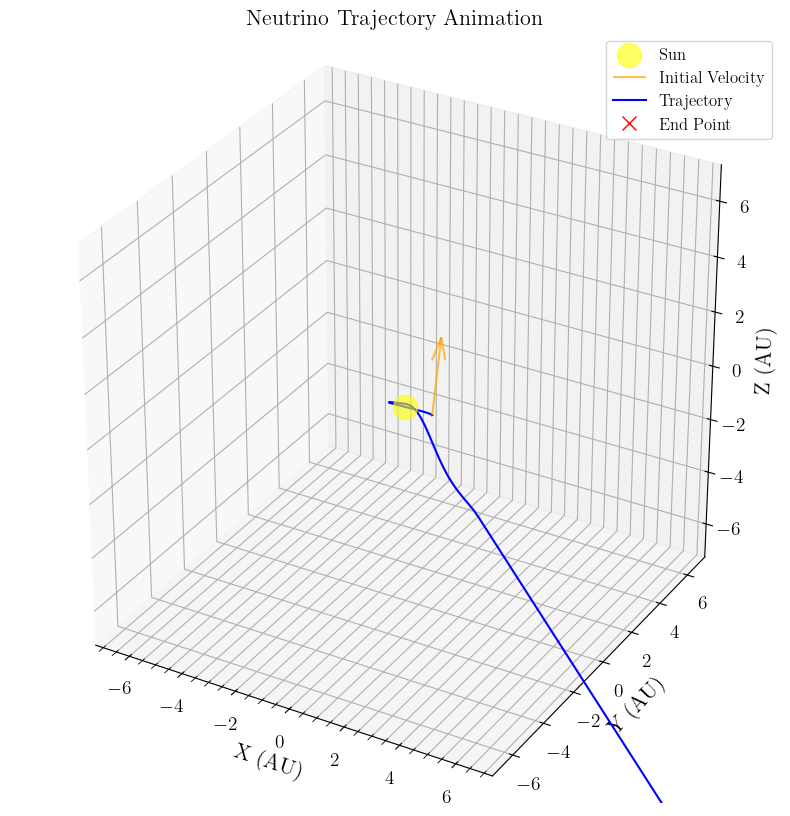

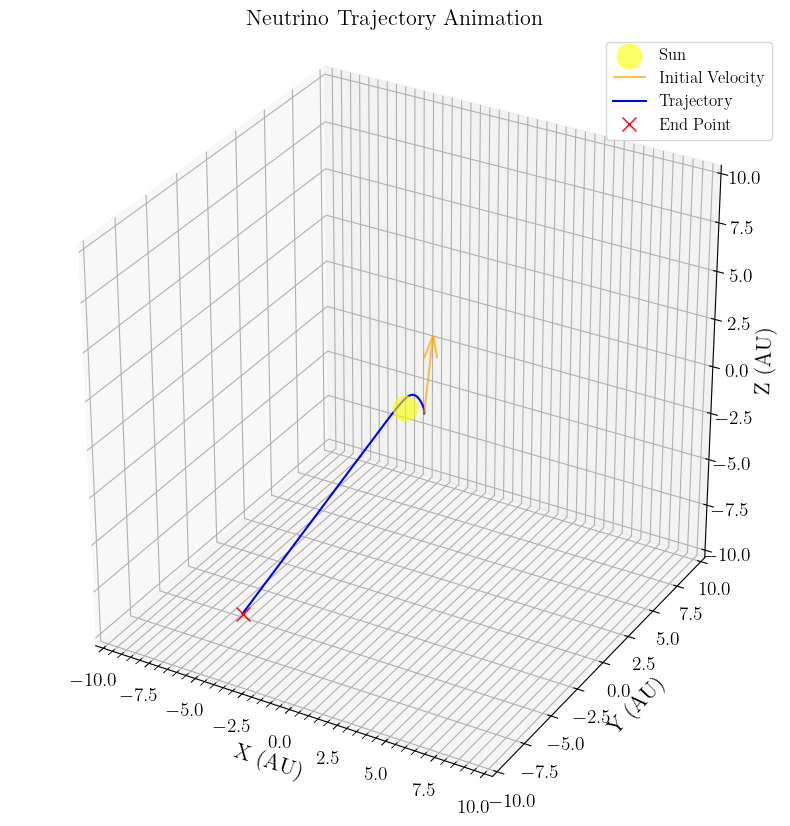

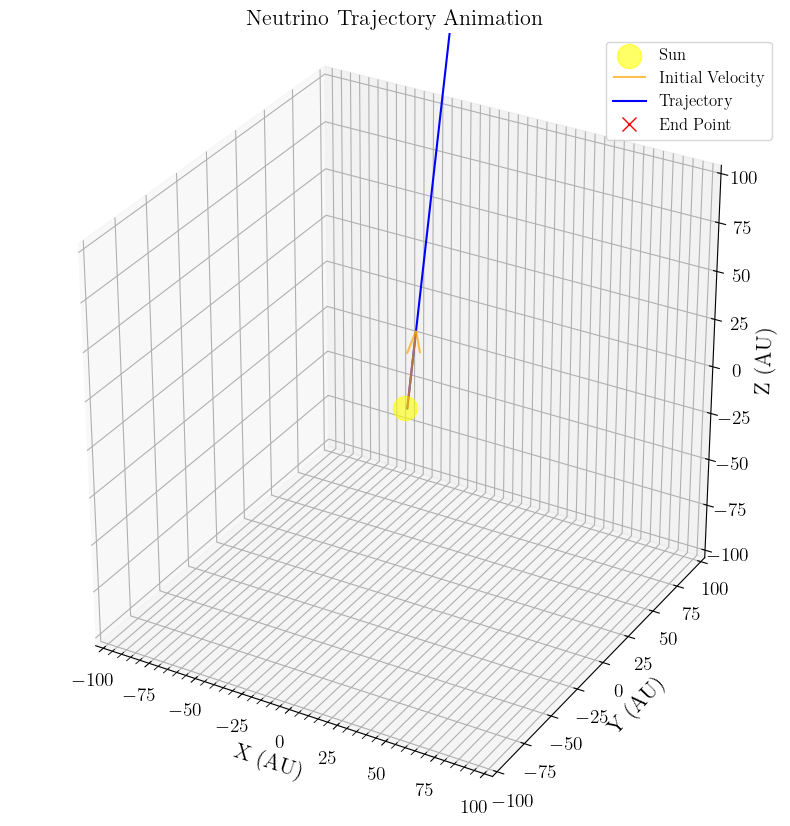

In [54]:
from matplotlib.animation import FuncAnimation

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

def animate_neutrino_trajectory(trajectory, interval=50, subsample=5, save_path=None, freeze_duration=2, elev=30, azim=-60, max_extent=None):
    # Extract positions (first 3 columns)
    positions = trajectory[:, :3] * Params.kpc / Params.AU
    print(f"Starting position [AU]: {positions[0]}")

    # Extract and calculate initial velocity
    vel0 = trajectory[:, 3:][0] * (Params.kpc/Params.s) / (Params.km/Params.s)
    print(f"Starting velocity [km/s]: {vel0}")

    # Find the last finite point (neither NaN nor inf)
    valid_mask = np.isfinite(positions).all(axis=1)
    valid_trajectory = positions[valid_mask][::subsample]

    # Calculate the maximum extent of the trajectory
    if max_extent is None:
        max_extent = np.max(np.abs(valid_trajectory))

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Set axis limits
    ax.set_xlim(-max_extent, max_extent)
    ax.set_ylim(-max_extent, max_extent)
    ax.set_zlim(-max_extent, max_extent)

    # Set labels
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_zlabel('Z (AU)')
    ax.set_title('Neutrino Trajectory Animation')

    # Plot the Sun
    ax.scatter(0, 0, 0, color='yellow', s=300, label='Sun', alpha=0.6)

    # Plot the initial velocity vector
    start_pos = valid_trajectory[0]
    velocity_scale = max_extent / np.linalg.norm(vel0) * 0.4  # Scale to 40% of plot size
    velocity_vector = -vel0 * velocity_scale
    quiver = ax.quiver(start_pos[0], start_pos[1], start_pos[2],
                       velocity_vector[0], velocity_vector[1], velocity_vector[2],
                       color='orange', label='Initial Velocity', alpha=0.7)

    # Initialize the line and point
    line, = ax.plot([], [], [], color='blue', label='Trajectory')
    point, = ax.plot([], [], [], 'bo', markersize=10, alpha=0.7)
    end_point, = ax.plot([], [], [], 'rx', markersize=10, label='End Point')

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Ensure equal aspect ratio
    ax.set_box_aspect((1, 1, 1))

    # Animation update function
    def update(frame):
        if frame < len(valid_trajectory):
            line.set_data(valid_trajectory[:frame, 0], valid_trajectory[:frame, 1])
            line.set_3d_properties(valid_trajectory[:frame, 2])
            point.set_data(valid_trajectory[frame:frame+1, 0], valid_trajectory[frame:frame+1, 1])
            point.set_3d_properties(valid_trajectory[frame:frame+1, 2])
            end_point.set_data([], [])
            end_point.set_3d_properties([])
        else:
            # Freeze frame: show the complete trajectory and end point
            line.set_data(valid_trajectory[:, 0], valid_trajectory[:, 1])
            line.set_3d_properties(valid_trajectory[:, 2])
            point.set_data([], [])
            point.set_3d_properties([])
            end_point.set_data([valid_trajectory[-1, 0]], [valid_trajectory[-1, 1]])
            end_point.set_3d_properties([valid_trajectory[-1, 2]])
        return line, point, end_point, quiver

    # Calculate total frames (including freeze frames)
    total_frames = len(valid_trajectory) + int(freeze_duration * 1000 / interval)

    # Create the animation
    anim = FuncAnimation(fig, update, frames=total_frames,
                         interval=interval, blit=True, repeat=False)

    # Add legend
    ax.legend()

    if save_path:
        # Save the animation
        anim.save(save_path, writer='pillow', fps=1000//interval)
    else:
        # Show the plot
        plt.show()

    return anim


animate_neutrino_trajectory(
    nu_vector_low, 
    interval=50, subsample=3, save_path='sim_plots_neutrino_trajectory_low.gif', freeze_duration=2, elev=30, azim=-60, max_extent=7)

animate_neutrino_trajectory(
    nu_vector_med, 
    interval=50, subsample=3, save_path='sim_plots_neutrino_trajectory_med.gif', freeze_duration=2, elev=30, azim=-60, max_extent=10)

animate_neutrino_trajectory(
    nu_vector_high, 
    interval=50, subsample=3, save_path='sim_plots_neutrino_trajectory_high.gif', freeze_duration=2, elev=30, azim=-60, max_extent=100)

### Check nan/inf consistency

In [ ]:
def check_nan_consistency(data):
    Npix, num_neutrinos, num_days, _ = data.shape
    
    # Initialize with -1 to indicate no NaNs found
    first_nan_day = -1
    consistent = True

    for direction in range(Npix):
        for neutrino in range(num_neutrinos):
            # Find the first day with NaN for this neutrino
            nan_mask = np.isnan(data[direction, neutrino, :, :]).any(axis=1)
            nan_days = np.where(nan_mask)[0]
            
            if len(nan_days) > 0:
                current_first_nan = nan_days[0]
                
                if first_nan_day == -1:
                    # This is the first NaN we've found, set it as the reference
                    first_nan_day = current_first_nan
                elif current_first_nan != first_nan_day:
                    # We found a NaN starting on a different day
                    consistent = False
                    print(f"Inconsistency found: Direction {direction}, Neutrino {neutrino} "
                          f"has first NaN on day {current_first_nan}")
                    return consistent, first_nan_day

    if first_nan_day == -1:
        print("No NaN values found in the dataset.")
    elif consistent:
        print(f"All NaN values consistently start on day {first_nan_day}")
    
    return consistent, first_nan_day


check_nan_consistency(nu_vectors_npix)

# Full-Sim: Analysis

ic| p_z4_sort.shape: (2, 5, 768, 1000)
ic| FD_vals.shape: (2, 5, 768, 1000)


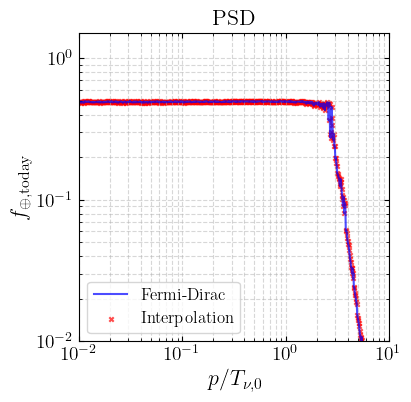

In [60]:
### ==================== ###
### Solar modulation sim ###
### ==================== ###

# Load velocities from day1
day1_vels = jnp.load(f"{sim_folder}/vectors_day1.npy")[..., 3:]

# note: vector contains only inf at z=4. Use double z=0 vectors for now
day1_vels_z0 = day1_vels[...,0,:]
day1_vels = jnp.repeat(day1_vels_z0[:, :, None, :], 2, axis=-2)[None, ...]

# Convert to momentum arrays (p and y)
p_day1, y_day1 = Physics.velocities_to_momenta_ND_halo_0th_axis(
    v_arr=day1_vels,
    m_arr=nu_m_picks,
    args=Params())

p_day1_z0 = p_day1[...,0]
p_day1_z4 = p_day1[...,-1]
y_day1_z0 = y_day1[...,0]

# Sort in ascending order of momentum array today
ind = p_day1_z0.argsort(axis=-1)
p_day1_z0_sort = jnp.take_along_axis(p_day1_z0, ind, axis=-1)
p_day1_z4_sort = jnp.take_along_axis(p_day1_z4, ind, axis=-1)
y_day1_z0_sort = jnp.take_along_axis(y_day1_z0, ind, axis=-1)

y_day1_z0_select = jnp.swapaxes(y_day1_z0_sort, -1, -2)[..., 0]
y_day1_z0_median = jnp.median(y_day1_z0_select, axis=0)


### ================== ###
### DM halo simulation ###
### ================== ###

# Neutrino velocities
vels = SimData.load_velocities(sim_dir=sim_folder, halo_num=2)

# Convert velocities to momenta
p_arr, y_arr = Physics.velocities_to_momenta_ND_halo_0th_axis(
    v_arr=vels, 
    m_arr=nu_m_picks,
    args=Params())

p_z0 = p_arr[...,0]
p_z4 = p_arr[...,-1]
y_z0 = y_arr[...,0]

# Sort in ascending order of momentum array today
ind = p_z0.argsort(axis=-1)
p_z4_sort = jnp.take_along_axis(p_z4, ind, axis=-1)
y_z0_sort = jnp.take_along_axis(y_z0, ind, axis=-1)

# x-axis
y_z0_select = jnp.swapaxes(y_z0_sort, -1, -2)[..., 0]
y_z0_median = jnp.median(y_z0_select, axis=0)


### ========================= ###
### Phase-space interpolation ###
### ========================= ###

# PSD using Fermi-Dirac assumption
ic(p_z4_sort.shape)
FD_vals = Physics.Fermi_Dirac(p_z4_sort, Params())
ic(FD_vals.shape)

# Select most (likely) clustered ones
FD_select = jnp.max(jnp.swapaxes(FD_vals, -1, -2), axis=-1)

# Use median or select 1 halo
# FD_median = jnp.median(FD_select, axis=0)
FD_median = FD_select[1]
# ic(FD_median.shape)

# Linear interpolation (for now) ... to get phase-space for modulation vectors
PSD_day1_masses_l = []
for mi, m in enumerate(nu_m_picks):
    PSD_day1_masses_l.append(jnp.array([Utils.jax_interpolate(
        x_target=x, x_points=y_z0_median[mi], y_points=FD_median[mi]) 
        for x in y_day1_z0_median[mi]]))
    
PSDs_day1 = jnp.repeat(
    jnp.array(PSD_day1_masses_l)[:, None, :], simdata.Npix, axis=-2)

def plot_PSD_and_interp(mi):
    fig = plt.figure(figsize=(4,4))
    fig.tight_layout()
    ax = fig.add_subplot(111)
    ax.plot(
        y_z0_median[mi], FD_median[mi], 
        color="blue", alpha=0.7, label="Fermi-Dirac")
    ax.scatter(
        y_day1_z0_median[mi], jnp.array(PSD_day1_masses_l)[mi], 
        color="red", marker="x", s=10, alpha=0.7, label="Interpolation")
    ax.set_title(fr"PSD")
    ax.set_ylim(1e-2, 1.5*1e0)
    ax.set_xlim(Params.p_start, 1e1)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$p/T_{\nu,0}$")
    ax.set_ylabel(r"$f_{\oplus,\mathrm{today}}$")
    ax.legend(loc="lower left")
    ax.grid(**Params.grid_dict)
    plt.show(); plt.close()

plot_PSD_and_interp(mi=-1)

In [56]:
print(PSDs_day1.shape)
print(PSDs_day1.min())
print(jnp.median(PSDs_day1[0,0]))

(5, 768, 1000)
5.403315681484663e-172
0.49937211455919817


In [61]:
### ================================= ###
### Compute number densities for day1 ###
### ================================= ###

#? some values are above 0.5 ...
PSDs_day1 = jnp.clip(PSDs_day1, a_min=None, a_max=0.5)

#? phase-space has to be sampled seperately for each pixel? I.e. each pixel has 1000 neutrinos with a PSD, which might differ (however slightly).
#? for now the sampling is from the "most likely clustered" PSD.

# Extend PSD array for now, see question above
y = p_day1_z0_sort**3 * PSDs_day1[None, ...]  # dlog integrand
x = p_day1_z0_sort
n_raw = trap(y, jnp.log(x), axis=-1)
# n_raw = jnp.sum(n_raw, axis=-1)

# Multiply by constants and/or solid angles and convert to 1/cm**3.
pix_sr = 4*Params.Pi/simdata.Npix
n_cm3 = pix_sr * Params.g_nu/((2*Params.Pi)**3) * n_raw / (1/Params.cm**3)
n_cm3_arr = jnp.array(n_cm3)
ic(n_cm3_arr.shape)
n_sum = jnp.sum(n_cm3_arr, axis=-1)
ic(n_sum[0])
ic("END")

ic| n_cm3_arr.shape: (1, 5, 768)
ic| n_sum[0]: Array([2.51960626e+02, 2.44652478e+04, 1.95314595e+05, 1.56208314e+06,
                     5.27185860e+06], dtype=float64)
ic| 'END'


'END'

# Plot outputs

/home/fabian/anaconda3/envs/neutrino_clustering/lib/python3.10/site-packages/matplotlib/ticker.py:2918: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/fabian/anaconda3/envs/neutrino_clustering/lib/python3.10/site-packages/matplotlib/ticker.py:2918: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/fabian/anaconda3/envs/neutrino_clustering/lib/python3.10/site-packages/matplotlib/ticker.py:2918: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/fabian/anaconda3/envs/neutrino_clustering/lib/python3.10/site-packages/matplotlib/ticker.py:2918: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


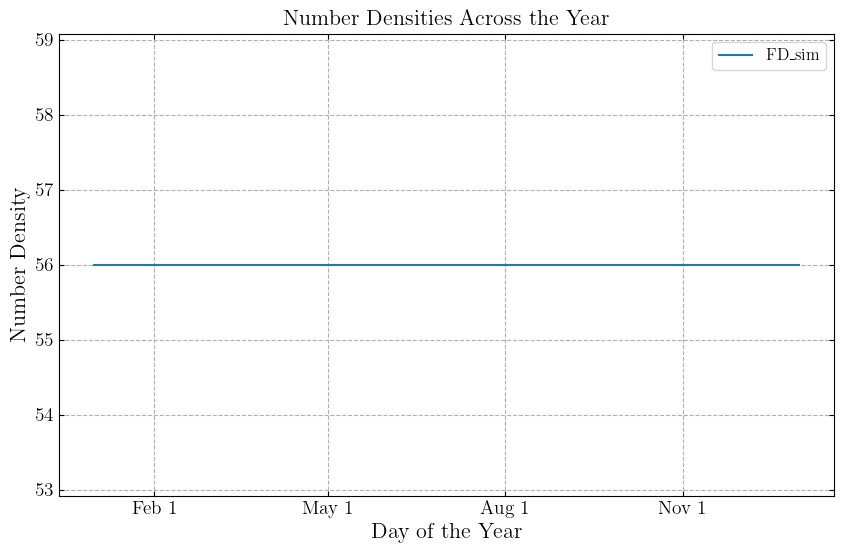

In [3]:
def modulation(nu_dens_days=None):
    
    # 1 to 365 for each day of the year
    days = jnp.arange(1, 366)
    
    # Placeholder, actual data after finishing project
    if nu_dens_days is None:
        nu_dens_days = jnp.ones_like(days)*56

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(days, nu_dens_days, label='FD_sim')

    # Customize x-axis to show ticks and labels only on specific dates
    tick_days = [305, 32, 122, 213]  # Corresponding to Nov 1, Feb 1, May 1, and Aug 1
    tick_labels = ['Nov 1', 'Feb 1', 'May 1', 'Aug 1']

    plt.xticks(tick_days, tick_labels)

    # Add labels and title
    plt.xlabel('Day of the Year')
    plt.ylabel('Number Density')
    plt.title('Number Densities Across the Year')
    plt.legend()

    # Show grid for better readability
    plt.grid(True, which="major", linestyle="dashed")

    # Display the plot
    plt.show()

modulation()